# 5. Visualizing Logistic Model Results

## 5.1 Imports

In [1]:
library(tidyverse)
library(ggimage)
library(here)

source(here("R", "00_source.R"))

specialistData <- read.csv(here("data", "specialist_data.csv"), 
                           na.strings = c('NA', NA, '', ' '))

FMDData <- read.csv(here("data", "FMD_data.csv"), 
                           na.strings = c('NA', NA, '', ' '))

FMDData$release <- as.factor(FMDData$release) 

# recreate model
fSelectedLogitAIC <- glm(fairCatch ~ timeToBeatVise + disFromReturner + disFromLOS + topSpeed, 
                    family = "binomial", 
                    data = FMDData)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at C:/Users/Hunter



## 5.2 Record Model Results
First, I will get each gunner's per-game averages. These values will be put into the model to predict their probability of causing a fair catch.

### 5.2.1 Create Dataframe to Store Gunner Data

In [2]:
gunners <- unique(specialistData$gunnerId)

gunnerRanked <- data.frame(gunnerId = gunners,
                           gunnerName = character(length(gunners)),
                           gunnerTeam = character(length(gunners)),
                           timeToBeatVise = numeric(length(gunners)),
                           disFromReturner = numeric(length(gunners)),
                           disFromLOS = numeric(length(gunners)),
                           topSpeed = numeric(length(gunners)),
                           FCP = numeric(length(gunners)),
                           playCount = numeric(length(gunners)))

### 5.2.2 Record Gunner Averages

In [3]:
for (i in 1:nrow(gunnerRanked)) {
  gunnerId <- gunnerRanked$gunnerId[i]
  gunnerRanked$gunnerName[i] <- specialistData$gunnerName[specialistData$gunnerId == gunnerId][1]
  gunnerRanked$gunnerTeam[i] <- specialistData$gunnerTeam[specialistData$gunnerId == gunnerId][1]
  gunnerRanked$timeToBeatVise[i] <- mean(specialistData$timeToBeatVise[specialistData$gunnerId == gunnerId], 
                                         na.rm = T)
  gunnerRanked$disFromReturner[i] <- mean(specialistData$disFromReturner[specialistData$gunnerId == gunnerId], 
                                          na.rm = T)
  gunnerRanked$disFromLOS[i] <- mean(specialistData$disFromLOS[specialistData$gunnerId == gunnerId], 
                                     na.rm = T)
  gunnerRanked$topSpeed[i] <- mean(specialistData$topSpeed[specialistData$gunnerId == gunnerId], 
                                na.rm = T)
  gunnerRanked$returnYds[i] <- mean(specialistData$returnYds[specialistData$gunnerId == gunnerId], 
                                    na.rm = T)
}

### 5.2.3 Predict Probability of Causing a Fair Catch Based on Averages

In [4]:
gunnerRanked$FCP <- predict(fSelectedLogitAIC, gunnerRanked[, 4:7], type = 'response')

### 5.2.4 Filter to Gunners Who Played in at Least 30 Plays

In [5]:
# get play count
gunnerRanked$playCount <- vapply(gunnerRanked$gunnerId, 
                                 function(x) length(which(specialistData$gunnerId == x)), 
                                 numeric(1))

# filter data
gunnerRankedQual <- gunnerRanked %>% filter(playCount >= 30)

## 5.3 Visualization
Here are the top 10 gunners in the NFL from 2018-2020 ranked by their predicted probability of causing a fair catch.

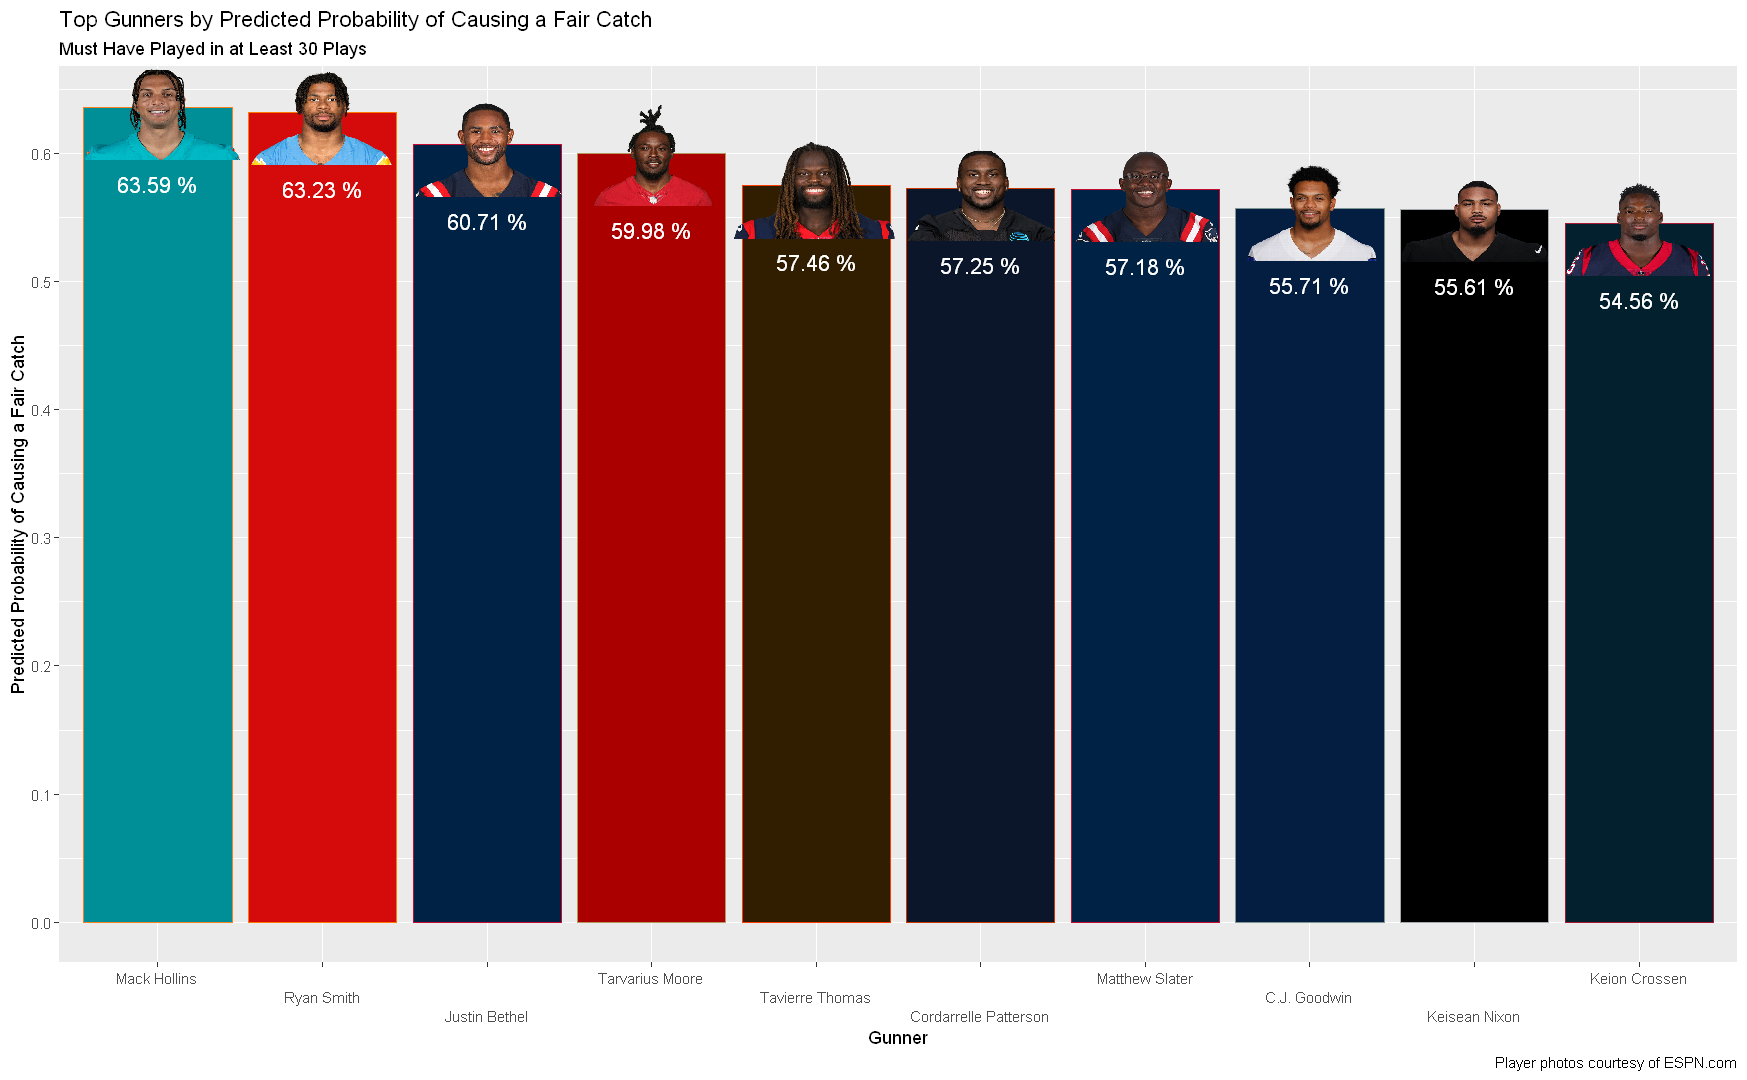

In [6]:
# adjust plot size
options(repr.plot.width=14.5623, repr.plot.height=9)

# get path to images
images <- c('m_hollins.png', 'r_smith.png', 'j_bethel.png', 't_moore.png', 't_thomas.png', 
            'c_patterson.png', 'm_slater.png', 'c_goodwin.png', 'k_nixon.png', 'k_crossen.png')

images <- here("images", images)

# scale images
asp_ratio <- 1.618 

# get top 10 gunners by probability of causing a fair catch
top10FCP <- gunnerRankedQual[order(-gunnerRankedQual$FCP), ][c(1:10),]
top10FCP$image <- images

# plot
ggplot() +
  geom_bar(data = top10FCP, aes(x=reorder(gunnerName, -FCP), y=FCP, fill=gunnerName, color = gunnerName), 
           stat='identity') +
  geom_image(data = top10FCP, aes(x=gunnerName, y=FCP, image = image),
             size = 0.1, by = 'width', asp = asp_ratio) +
  geom_text(data = top10FCP, aes(x = gunnerName, y = FCP, label = paste(format(round(FCP * 100, 2),
                                                                               nsmall = 2), '%'), 
                                 vjust=5, color = 'white', size = 3.5)) +
  labs(title='Top Gunners by Predicted Probability of Causing a Fair Catch', 
       subtitle = 'Must Have Played in at Least 30 Plays', 
       caption = 'Player photos courtesy of ESPN.com') +
  scale_y_continuous(breaks = seq(0, 0.8, 0.1)) +
  scale_x_discrete(guide = guide_axis(n.dodge=3)) +
  xlab('Gunner') +
  ylab('Predicted Probability of Causing a Fair Catch') +
  theme(legend.position = "none") +
  scale_fill_manual(values = c('#041E42', '#0B162A', '#002244', '#03202f', '#000000', 
                               '#008E97', '#002244', '#D50A0A', '#AA0000', '#311D00')) +
  scale_color_manual(values = c('#7F9695', '#c83803', '#C60C30', '#A71930', '#A5ACAF', 
                                '#F58220', '#C60C30', '#FF7900', '#B3995D', '#ff3c00', '#FFFFFF'))

## 5.4 Write to .csv

In [7]:
write.csv(gunnerRankedQual, file = here("data", "gunner_stats_FCP.csv"), row.names = FALSE)

## 5.5 Save Plot

In [8]:
ggsave("FCP.png", path = here("output"), width = 9.7082, height = 6)